In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.utils.read.flac('speech/7021-79759-0004.flac')
len(y), sr

(391520, 16000)

### Load WebRTC

```python
def webrtc(
    aggressiveness: int = 3,
    sample_rate: int = 16000,
    minimum_amplitude: int = 100,
):
    """
    Load WebRTC VAD model.

    Parameters
    ----------
    aggressiveness: int, optional (default=3)
        an integer between 0 and 3.
        0 is the least aggressive about filtering out non-speech, 3 is the most aggressive.
    sample_rate: int, optional (default=16000)
        sample rate for samples.
    minimum_amplitude: int, optional (default=100)
        minimum_amplitude to assume a sample is a voice activity. Else, automatically False.

    Returns
    -------
    result : malaya_speech.model.webrtc.WEBRTC class
    """
```

WebRTC developed by Google, reportedly one of the best available, being fast, modern and free. Read more about pywebrtc at https://github.com/wiseman/py-webrtcvad.

In [3]:
vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y), 0.2)))

In [4]:
model = malaya_speech.vad.deep_model()

### How to detect Voice Activity

In order to use available Malaya-Speech VAD models, we need to split our audio sample into really small chunks. 

For Google WebRTC, we need to split by every 30 ms. For deep learning, we trained on 30 ms, 90 ms and random length less than 300 ms.

To split an audio sample by giving time split, use, [malaya_speech.utils.generator.frames]()

```python
def frames(
    audio,
    frame_duration_ms: int = 30,
    sample_rate: int = 16000,
    append_ending_trail: bool = True,
):
    """
    Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and the sample rate.

    Parameters
    ----------

    audio: np.array / list
    frame_duration_ms: int, optional (default=30)
    sample_rate: int, optional (default=16000)
    append_ending_trail: bool, optional (default=True)
        if True, will append last trail and this last trail might not same length as `frame_duration_ms`.

    Returns
    -------
    result: List[malaya_speech.model.frame.FRAME]
    """
```

In [5]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

CPU times: user 862 µs, sys: 51 µs, total: 913 µs
Wall time: 920 µs


In [6]:
%%time

frames_webrtc = [(frame, vad(frame)) for frame in frames]

CPU times: user 19 ms, sys: 395 µs, total: 19.4 ms
Wall time: 19.8 ms


In [7]:
%%time

frames_deep = [(frame, model(malaya_speech.utils.astype.int_to_float(frame))) for frame in frames]

CPU times: user 4min 49s, sys: 48.7 s, total: 5min 37s
Wall time: 1min 4s


**To speedup, you can do pipeline batching to utilize parallel processing or use GPU or both**.

#### Batching pipeline

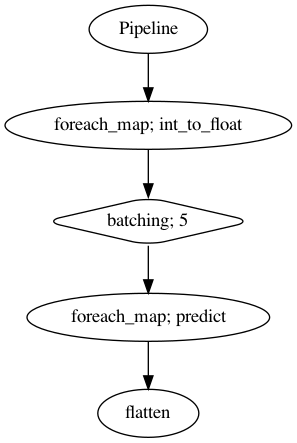

In [8]:
p = Pipeline()
pipeline = (
    p.foreach_map(malaya_speech.utils.astype.int_to_float)
    .batching(5)
    .foreach_map(model.predict)
    .flatten()
)
p.visualize()

In [9]:
%%time

result = p.emit(frames)
result.keys()

CPU times: user 5min 12s, sys: 54.6 s, total: 6min 6s
Wall time: 1min 10s


dict_keys(['int_to_float', 'batching', 'predict', 'flatten'])

In [10]:
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

`frames_deep` == `frames_deep_batch`.

### VAD Visualization

We can visualize our audio sample to annotate which parts are active speech or not.

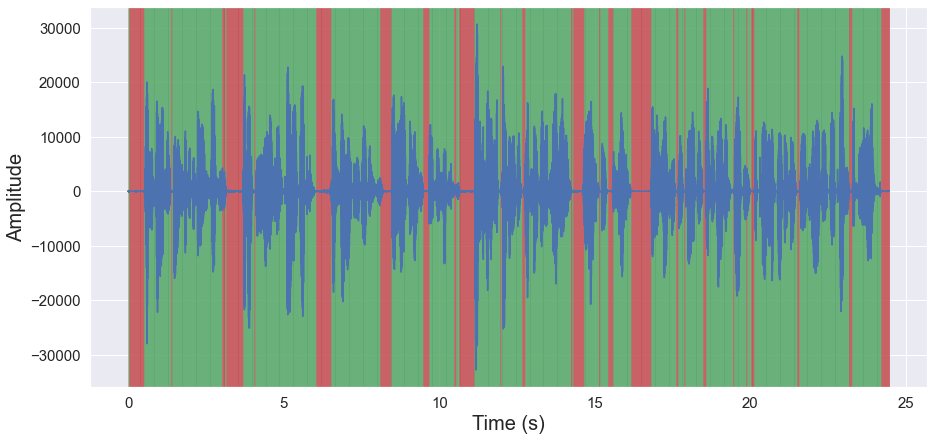

In [11]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

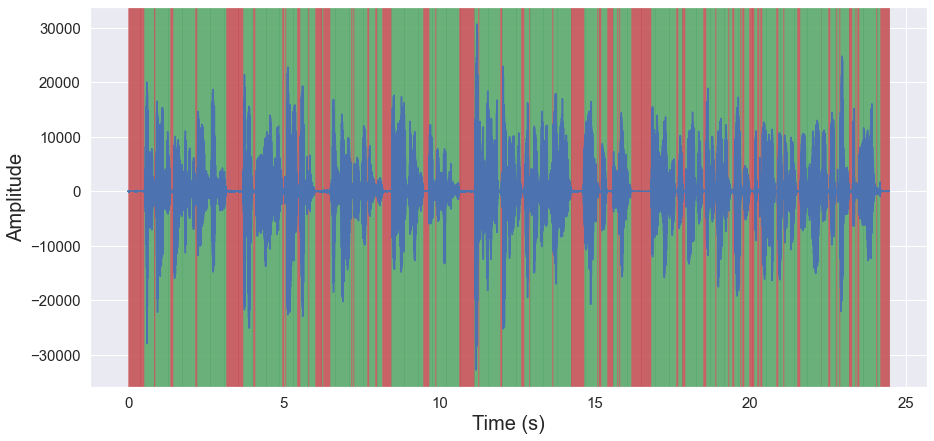

In [12]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep, sr)

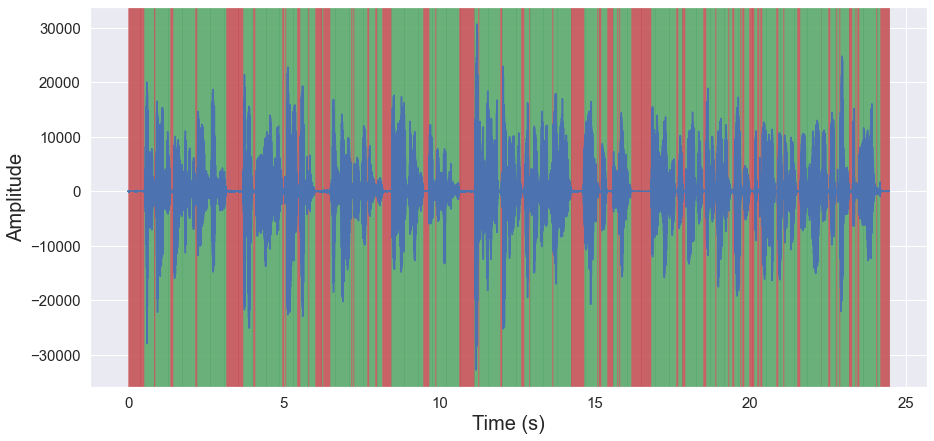

In [13]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

### Groupby VAD

To group small samples into larger samples, use [malaya_speech.vad.group_vad]()

In [14]:
grouped_vad = malaya_speech.vad.group_vad(frames_webrtc)
grouped_deep = malaya_speech.vad.group_vad(frames_deep)

In [15]:
len(frames), len(grouped_vad), len(grouped_deep)

(816, 52, 111)

### Harder example

In the real world, not all samples recorded in clean cut studio, full with background noises, music and etc. So those are not the real voice activities. Lets take noise sound,

In [16]:
y, sr = malaya_speech.utils.read.wav('speech/noise/n98.wav')
len(y), sr

(64000, 16000)

In [17]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

CPU times: user 348 µs, sys: 12 µs, total: 360 µs
Wall time: 367 µs


In [22]:
%%time

vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y), 0.2)))
frames_webrtc = [(frame, vad(frame)) for frame in frames]

CPU times: user 4.41 ms, sys: 2 µs, total: 4.42 ms
Wall time: 4.43 ms


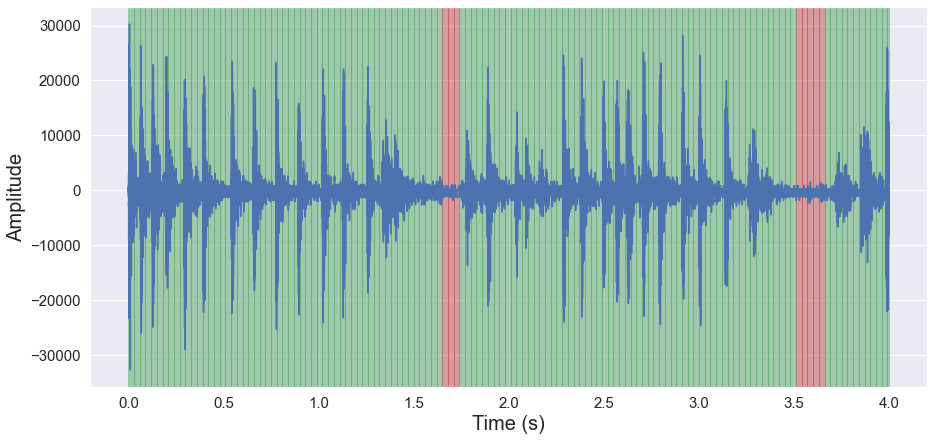

In [23]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

In [24]:
%%time

result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=320
  n_fft, y.shape[-1]


CPU times: user 42.4 s, sys: 7.92 s, total: 50.3 s
Wall time: 9.38 s


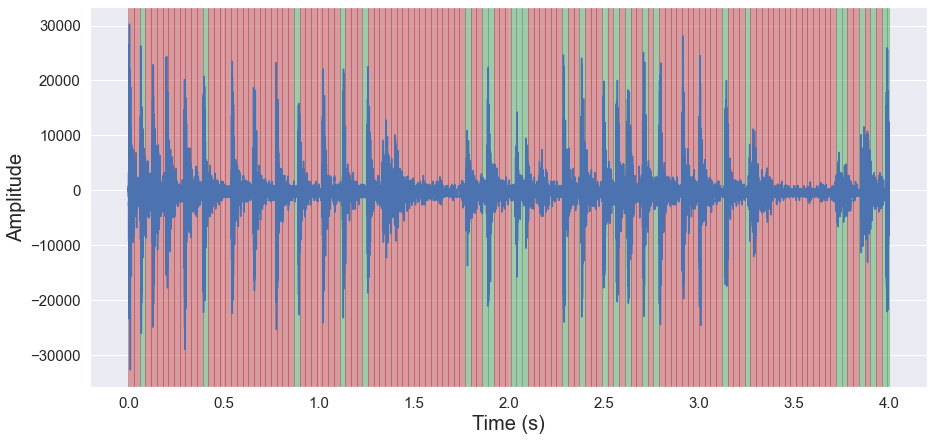

In [25]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

As you can see, the deep model able to know this sample mostly noises!

In [29]:
y, sr = malaya_speech.utils.read.wav('speech/podcast/2x5%20Ep%2010.wav')
y = y[: sr * 10]
len(y), sr

(160000, 16000)

In [30]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

In [31]:
%%time

vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y), 0.2)))
frames_webrtc = [(frame, vad(frame)) for frame in frames]

CPU times: user 12.6 ms, sys: 2.83 ms, total: 15.4 ms
Wall time: 14.2 ms


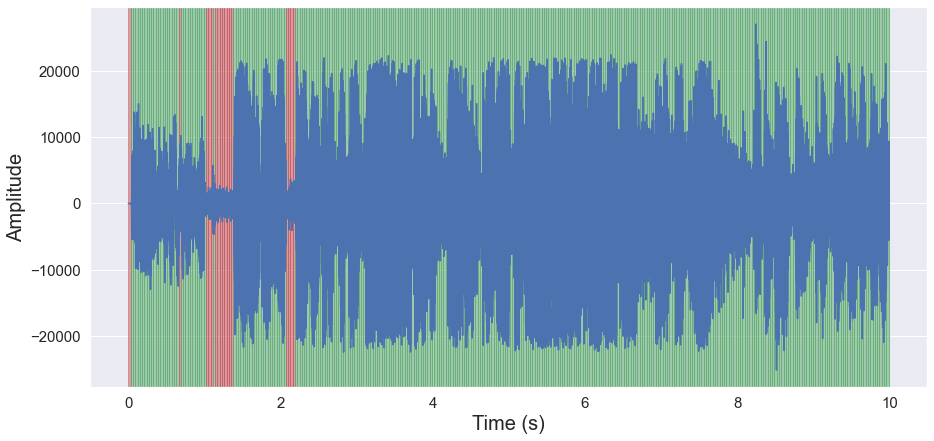

In [32]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

In [33]:
%%time

result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=320
  n_fft, y.shape[-1]


CPU times: user 1min 50s, sys: 20.6 s, total: 2min 10s
Wall time: 23.6 s


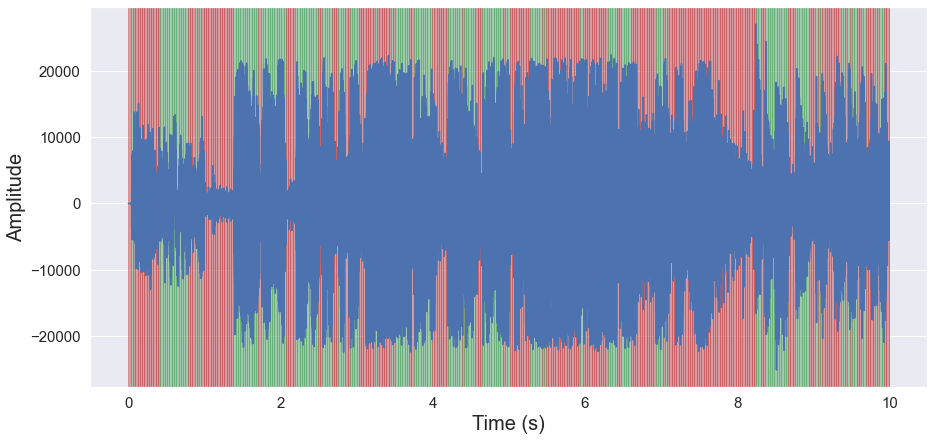

In [34]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

In [35]:
import IPython.display as ipd
ipd.Audio(y, rate = sr)